# Projekt - Analiza tekstu z mediów społecznościowych

#### Kacper Hołowaty - 10 czerwca 2024

## Wstęp

W tym projekcie zająłem się analizą opinii z Twittera na temat, zdaniem wielu, najlepszej ligi piłkarskiej świata - Premier League (**#premierleague**). Baza danych, z której korzystam, w początkowej formie zawiera pola: Content - zawierające treść tweeta, Date - data publikacji tweeta oraz Lang - język w jakim napisany został dany tweet. Baza ma dokładnie 12000 tweetów opublikowanych od 2019 do 2023, gdzie co miesiąc pobierane było 250 tweetów.  

In [2]:
import pandas as pd

df = pd.read_csv('tweets.csv')
print(df)

                                                 Content        Date Lang
0      @THEUNITEDVOICE2 @Intuitive_boy @TheManUtdWay ...  2019-06-29   en
1      @TravellingToque @stighefootball There is a Pr...  2019-06-29   en
2      @EverythingSpur3 Doherty . Proven in the premi...  2019-06-29   en
3      @Quartermain10 @NMFCOfficial Yeh, Man U though...  2019-06-29   en
4      @peasandkaris @RapidsJason @kevguest @caitlinm...  2019-06-29   en
...                                                  ...         ...  ...
11995  @MadridXtra @marca Watch out Premier League, M...  2023-05-30   en
11996  @RishiSunak why are people who illegally strea...  2023-05-30   en
11997  @Emperor_simon @premierleague @topradio909 @Ba...  2023-05-30   en
11998  @PLComms The premier league rip people off! Th...  2023-05-30   en
11999  @ChelseaFCSkye @RealFalseNine You really do ob...  2023-05-30   en

[12000 rows x 3 columns]


## Preprocessing

Podstawowym etapem analizy wpisów z mediów społecznościowych jest preprocessing. Z racji iż Premier League jest ligą o zasięgu globalnym, naturalnym jest, że wpisy na jej temat występują nie tylko w języku angielskim. W związku z tym pierwszym etapem preprocessingu było przetłumaczenie wszystkich tweetów na język angielski. Do tego celu użyłem paczki **googletrans**, a wyniki, dla ułatwienia zapisałem w pliku translated_tweets.csv.

In [2]:
from googletrans import Translator

def translate_tweets(df):
    translator = Translator(service_urls=['translate.googleapis.com'])
    translated_tweets = []

    for index, row in df.iterrows():
        tweet_content = row['Content']
        lang = row['Lang']
        translated_tweet = tweet_content

        if lang != 'en':
            try:
                if lang == 'in':
                    translated_tweet = translator.translate(tweet_content, dest='en', src='es').text
                elif lang == 'zh':
                    translated_tweet = translator.translate(tweet_content, dest='en', src='zh-cn').text
                elif lang not in ['zxx', 'und', 'qme', 'qht', 'qst', 'qam']:
                    translated_tweet = translator.translate(tweet_content, dest='en', src=lang).text
            except Exception as e:
                print(f"Error translating tweet at index {index}: {e}")
                continue

        translated_tweets.append({'Content': translated_tweet, 'Date': row['Date']})

    df_translated = pd.DataFrame(translated_tweets)
    df_translated.to_csv('translated_tweets.csv', index=False, encoding='utf-8')
    print("Przetłumaczono i zapisano tweety do pliku translated_tweets.csv")

translate_tweets(df)

Przetłumaczono i zapisano tweety do pliku translated_tweets.csv


Następnie robiąc preprocessing danych, po pierwsze stworzyłem funkcję odpowiadającą za przetworzenie pojedynczego tweet'a, między innymi zamieniając duże litery na małe, usuwając wszystkie znaki nie będące znakami alfanumerycznymi, spacjami czy tabulatorami. Dodatkowo usunąłem również nazwy użytkowników, zastosowałem rózne kroki dla Bag of Words czyli tokenizację, stopwords, do których dodałem kilka słów, które w mojej opinii nic nie wnosiły (nie miały wyraźnie przypisanego wydźwięku emocjonalnego), a występowały bardzo często oraz zastosowałem lematyzację dla wszystkich wpisów. Następnie pobrałem wcześniej przygotowane, przetłumaczone tweety z pliku translated_tweets.csv i dla każdego z nich zastosowałem tą funkcję i ponownie zapisałem dane, tym razem do pliku preprocessed_tweets.csv.  

In [4]:
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

def preprocess_tweet(tweet):
    tweet = tweet.lower()
    tweet = re.sub(r'@\w+', '', tweet)
    tweet = re.sub(r'[^\w\s]', '', tweet)

    tokens = word_tokenize(tweet)
    tokens = [token for token in tokens if token.isalpha()]

    stop_words = stopwords.words('english')
    stop_words.extend(['premier', 'league', 'premierleague'])
    tokens = [token for token in tokens if token not in stop_words]

    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    preprocessed = ' '.join(tokens)
    return preprocessed

def preprocess_tweets():
    df_translated = pd.read_csv('translated_tweets.csv', encoding='utf-8')

    df_translated['Content'] = df_translated['Content'].apply(preprocess_tweet)

    df_translated.to_csv('preprocessed_tweets.csv', index=False, encoding='utf-8')
    print('Przetworzono wszystkie tweety i zapisano je do pliku preprocessed_tweets.csv')

preprocess_tweets()

print("Tweety po preprocessingu wyglądają następująco:")
df = pd.read_csv('preprocessed_tweets.csv')
print(df)

Przetworzono wszystkie tweety i zapisano je do pliku preprocessed_tweets.csv
Tweety po preprocessingu wyglądają następująco:
                                                 Content        Date
0      isnt team isnt bench either martial goal whole...  2019-06-29
1                                  price inflation crazy  2019-06-29
2                   doherty proven brilliant last season  2019-06-29
3      yeh man u thought thing solskaer year signed t...  2019-06-29
4      actually got soccer usmnt watching started goi...  2019-06-29
...                                                  ...         ...
11995  watch marco asensio take storm unai emery guid...  2023-05-30
11996  people illegally stream football serving much ...  2023-05-30
11997                                     winning enough  2023-05-30
11998  rip people disgusting corrupt profit driven an...  2023-05-30
11999  really ob american player bamford koch firpo g...  2023-05-30

[12000 rows x 2 columns]


## Analiza opinii

#### Analiza całościowa

W tym etapie tworzę wykresy pokazujące najczęściej występujące słowa we wszystkich postach na temat Premier League, czyli chmurę tagów dla wszystkich słów oraz wykres słupkowy dla 10 najczęściej powtarzających się słów.

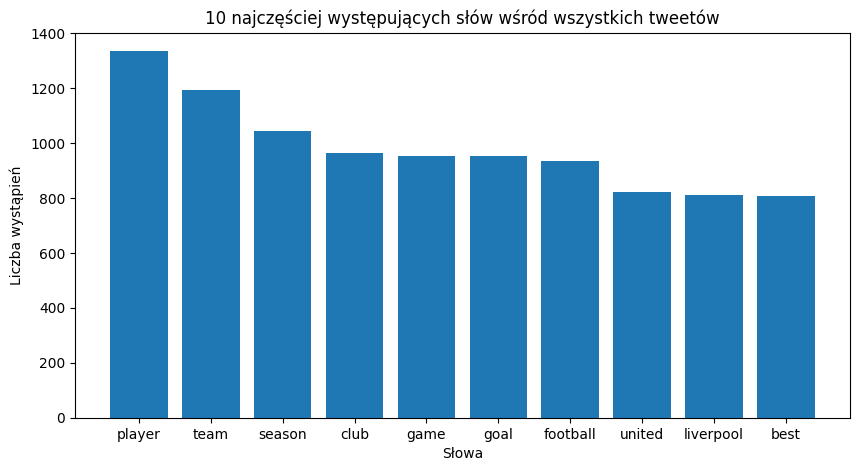

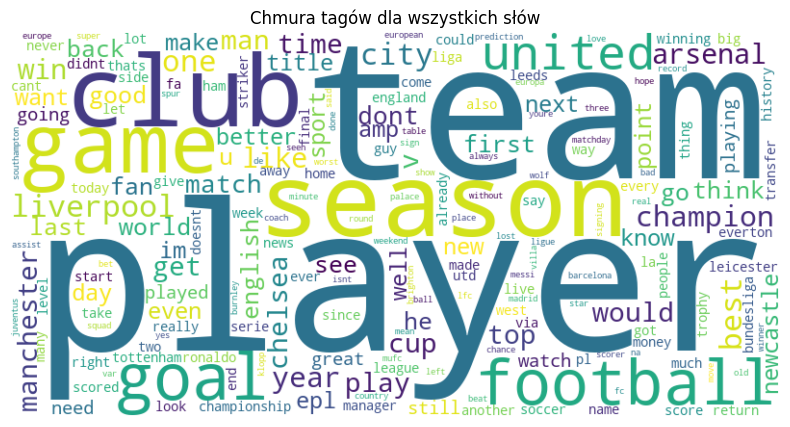

In [5]:
from nltk.probability import FreqDist
from wordcloud import WordCloud
import matplotlib.pyplot as plt

df['Content'] = df['Content'].astype(str).fillna('')
tweets = [tweet.split() for tweet in df['Content']]

all_words = [word for tweet in tweets for word in tweet]
fd = FreqDist(all_words)

most_common_words = fd.most_common(10)
words, counts = zip(*most_common_words)
wordcloud_all = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(fd)

plt.figure(figsize=(10, 5))
plt.bar(words, counts)
plt.xlabel('Słowa')
plt.ylabel('Liczba wystąpień')
plt.title('10 najczęściej występujących słów wśród wszystkich tweetów')
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_all, interpolation='bilinear')
plt.axis('off')
plt.title('Chmura tagów dla wszystkich słów')
plt.show()

#### Chmury tagów dla tweetów o różnych emocjach

W tym podpunkcie tworzę i wyświetlam chmury tagów dla emocji pozytywnych, negatywnych i neutralnych korzystając z **SentimentIntensityAnalyzer** z paczki **nltk.sentiment.vader**, jak i również dla emocji: Happy, Sad, Angry, Fear oraz Surprise, które uzyskuję korzystając z funkcji **get_emotion** z paczki **text2emotion** oraz również dla każdej z tych emocji wyświetlam 10 najczęściej wystepujących słów. 

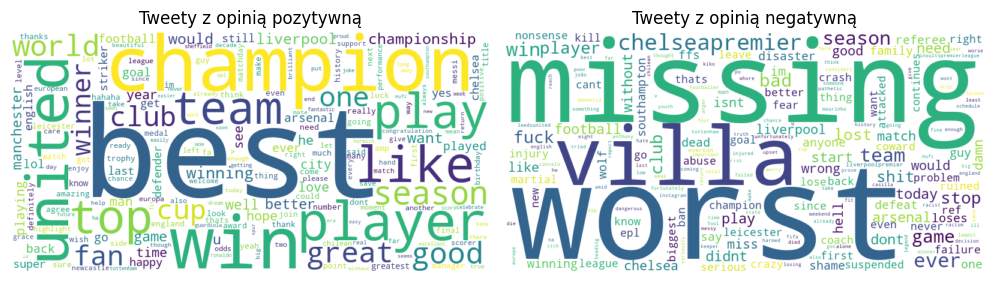

In [12]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
sentiments = [sid.polarity_scores(' '.join(tweet)) for tweet in tweets]

positive_tweets = [tweet for tweet, sentiment in zip(tweets, sentiments) if sentiment['pos'] > 0.5 > sentiment['neu'] and sentiment['pos'] > sentiment['neg']]
negative_tweets = [tweet for tweet, sentiment in zip(tweets, sentiments) if sentiment['neg'] > 0.5 > sentiment['neu'] and sentiment['neg'] > sentiment['pos']]

positive_words = [word for tweet in positive_tweets for word in tweet]
positive_words_freq = FreqDist(positive_words)
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(positive_words_freq)

negative_words = [word for tweet in negative_tweets for word in tweet]
negative_words_freq = FreqDist(negative_words)
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(negative_words_freq)

plt.figure(figsize=(15, 5))

plt.subplot(132)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Tweety z opinią pozytywną')

plt.subplot(133)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Tweety z opinią negatywną')

plt.tight_layout()
plt.show()

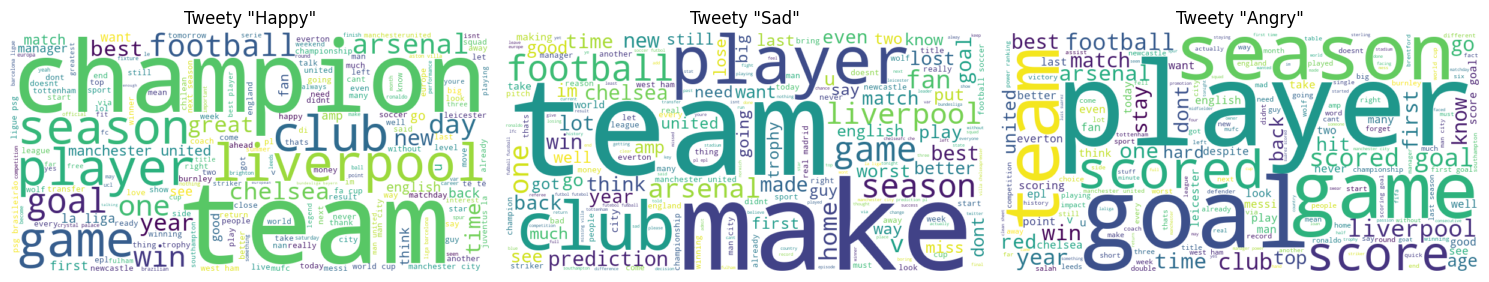

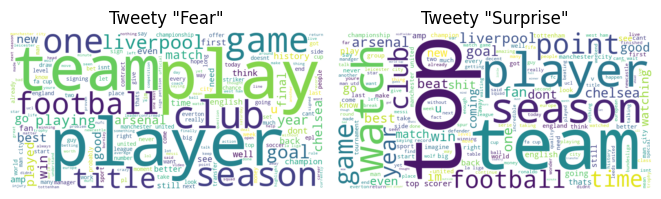

In [16]:
import text2emotion as te


def make_wordcloud(tweets):
    wordcloud_text = ' '.join(tweets)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(wordcloud_text)
    return wordcloud

happy_tweets = []
sad_tweets = []
angry_tweets = []
fear_tweets = []
surprise_tweets = []

for tweet in tweets:
    full_tweet = ""
    for word in tweet:
        full_tweet += word + " "
    emotions = te.get_emotion(full_tweet)

    main_emotion = max(emotions, key=emotions.get)

    if main_emotion == 'Happy':
        happy_tweets.append(full_tweet)
    elif main_emotion == 'Sad':
        sad_tweets.append(full_tweet)
    elif main_emotion == 'Angry':
        angry_tweets.append(full_tweet)
    elif main_emotion == 'Fear':
        fear_tweets.append(full_tweet)
    elif main_emotion == 'Surprise':
        surprise_tweets.append(full_tweet)

happy_wc = make_wordcloud(happy_tweets)
sad_wc = make_wordcloud(sad_tweets)
angry_wc = make_wordcloud(angry_tweets)
fear_wc = make_wordcloud(fear_tweets)
surprise_wc = make_wordcloud(surprise_tweets)

plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.imshow(happy_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Tweety "Happy"')

plt.subplot(132)
plt.imshow(sad_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Tweety "Sad"')

plt.subplot(133)
plt.imshow(angry_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Tweety "Angry"')

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))

plt.subplot(131)
plt.imshow(fear_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Tweety "Fear"')

plt.subplot(132)
plt.imshow(surprise_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Tweety "Surprise"')

plt.tight_layout()
plt.show()

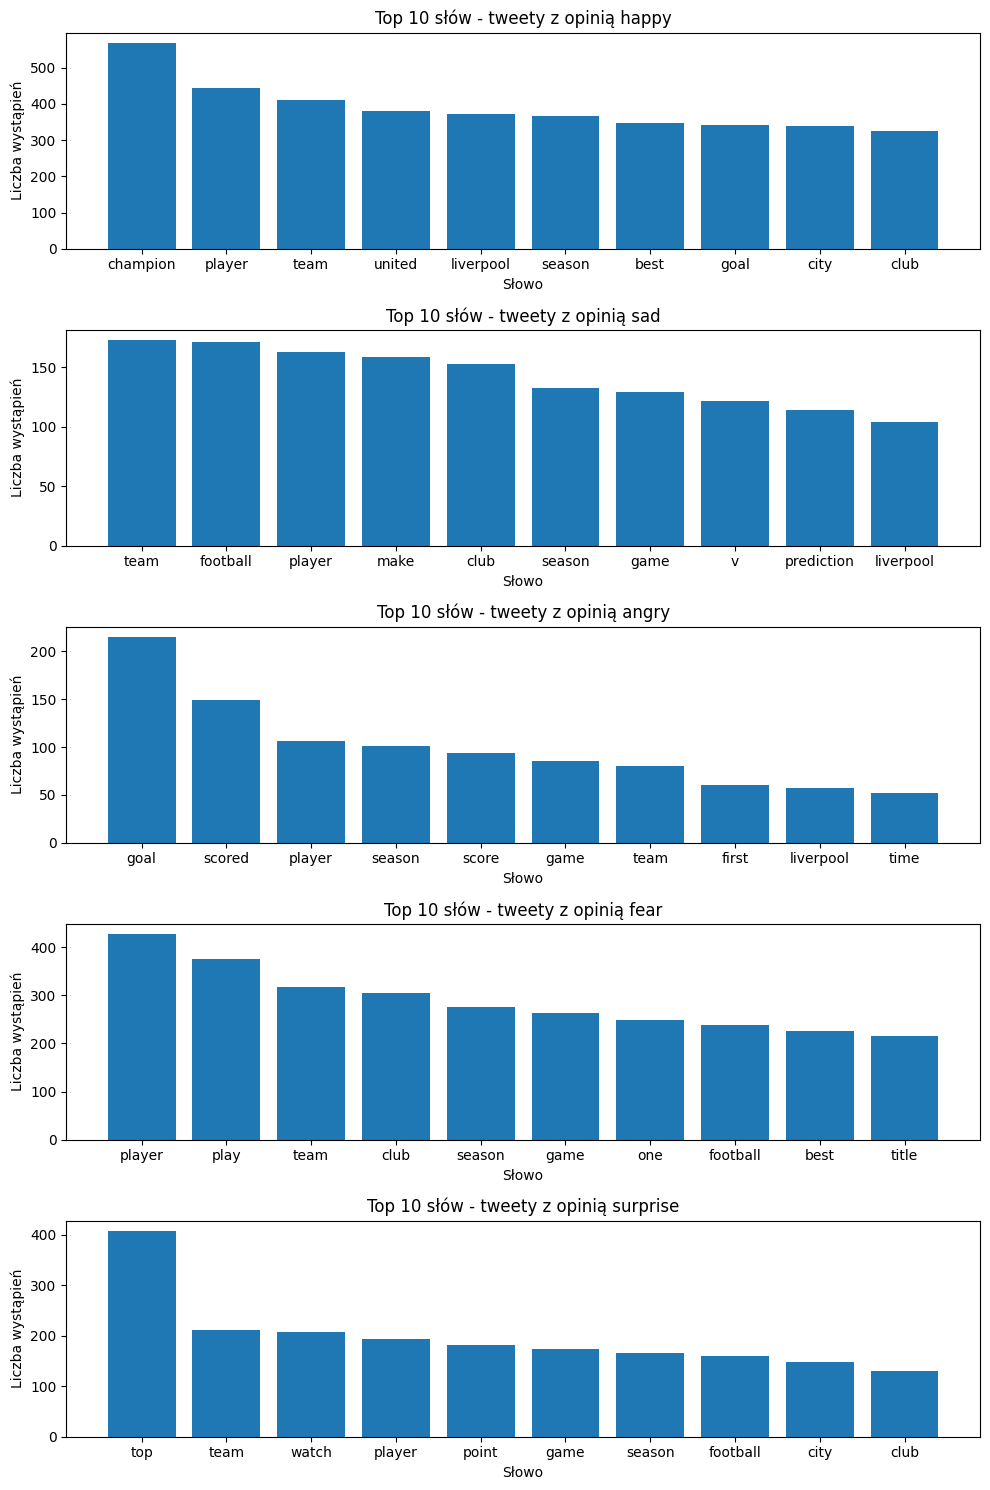

In [17]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10, 15))

happy_words = [word for tweet in happy_tweets for word in tweet.split()]
happy_words_freq = FreqDist(happy_words)
axes[0].bar(*zip(*happy_words_freq.most_common(10)))
axes[0].set_title('Top 10 słów - tweety z opinią happy')
axes[0].set_xlabel('Słowo')
axes[0].set_ylabel('Liczba wystąpień')

sad_words = [word for tweet in sad_tweets for word in tweet.split()]
sad_words_freq = FreqDist(sad_words)
axes[1].bar(*zip(*sad_words_freq.most_common(10)))
axes[1].set_title('Top 10 słów - tweety z opinią sad')
axes[1].set_xlabel('Słowo')
axes[1].set_ylabel('Liczba wystąpień')

angry_words = [word for tweet in angry_tweets for word in tweet.split()]
angry_words_freq = FreqDist(angry_words)
axes[2].bar(*zip(*angry_words_freq.most_common(10)))
axes[2].set_title('Top 10 słów - tweety z opinią angry')
axes[2].set_xlabel('Słowo')
axes[2].set_ylabel('Liczba wystąpień')

fear_words = [word for tweet in fear_tweets for word in tweet.split()]
fear_words_freq = FreqDist(fear_words)
axes[3].bar(*zip(*fear_words_freq.most_common(10)))
axes[3].set_title('Top 10 słów - tweety z opinią fear')
axes[3].set_xlabel('Słowo')
axes[3].set_ylabel('Liczba wystąpień')

surprise_words = [word for tweet in surprise_tweets for word in tweet.split()]
surprise_words_freq = FreqDist(surprise_words)
axes[4].bar(*zip(*surprise_words_freq.most_common(10)))
axes[4].set_title('Top 10 słów - tweety z opinią surprise')
axes[4].set_xlabel('Słowo')
axes[4].set_ylabel('Liczba wystąpień')

plt.tight_layout()
plt.show()


#### Analiza czasowa

W tym podpunkcie zajmę się analizą czasową, która polega na narysowaniu wykresu liniowego. Dla **text2emotion** tweety są dzielone na 5 emocji, które potem są rysowane jako linie na jednym wspólnym wykresie. Podobny wykres rysujemy dla emocji uzyskach z **nltk.sentiment.vader**.

Przetworzono emocje dla 1000 tweetów
Przetworzono emocje dla 2000 tweetów
Przetworzono emocje dla 3000 tweetów
Przetworzono emocje dla 4000 tweetów
Przetworzono emocje dla 5000 tweetów
Przetworzono emocje dla 6000 tweetów
Przetworzono emocje dla 7000 tweetów
Przetworzono emocje dla 8000 tweetów
Przetworzono emocje dla 9000 tweetów
Przetworzono emocje dla 10000 tweetów
Przetworzono emocje dla 11000 tweetów
Przetworzono emocje dla 12000 tweetów


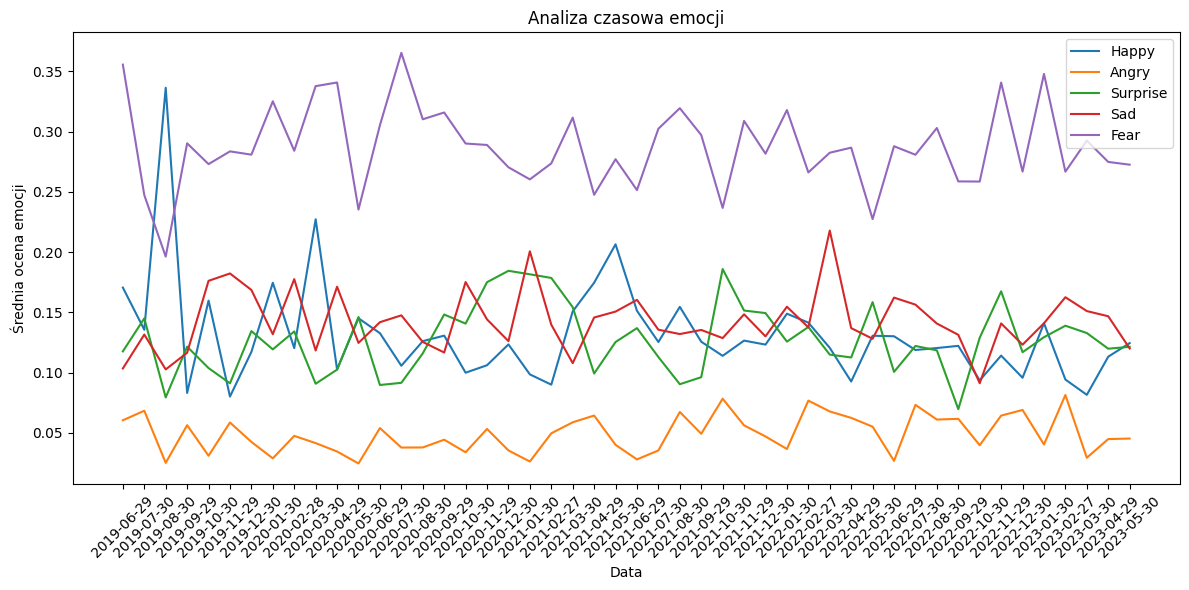

In [27]:
from collections import defaultdict

emotions = ['Happy', 'Angry', 'Surprise', 'Sad', 'Fear']
progress_interval = 1000

dates_emotions = defaultdict(lambda: defaultdict(list))
progress_counter = 0

for index, row in df.iterrows():
    tweet = row['Content']
    date = row['Date']
    
    emotion_scores = te.get_emotion(tweet)
    
    for emotion in emotions:
        dates_emotions[date][emotion].append(emotion_scores[emotion])
    
    progress_counter += 1
    if progress_counter % progress_interval == 0:
        print(f'Przetworzono emocje dla {progress_counter} tweetów')


dates = list(dates_emotions.keys())

plt.figure(figsize=(12, 6))

for emotion in emotions:
    average_emotions = []
    for date in dates:
        scores = dates_emotions[date][emotion]
        if scores:
            average_emotions.append(sum(scores) / len(scores))
        else:
            average_emotions.append(0)
    plt.plot(dates, average_emotions, label=emotion)

plt.xlabel('Data')
plt.ylabel('Średnia ocena emocji')
plt.title('Analiza czasowa emocji')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

Z powyższego wykresu możemy wyczytać, że najczęściej występującą emocją w pobranych tweetach jest 'Fear'. Ciekawa sytuacja ma natomiast miejsce w lipcu 2019 roku, gdzie widać nagły wzrost dla emocji 'Happy', jednak nie wiem z czego on może wynikać, gdyż jak sprawdzałem, nic konkretnego wtedy się nie wydarzyło. Wzrost dla emocji 'Happy' już nie tak duży, widać także w lutym 2020 roku, co przypada na początek pandemii. Ostatnią emocją, którą jakkolwiek można połączyć z jakimś wydarzeniem jest wybuch wojny na Ukrainie w lutym 2022 roku, co powoduje wzrost emocji 'Sad'.  

Przetworzono emocje dla 1000 tweetów
Przetworzono emocje dla 2000 tweetów
Przetworzono emocje dla 3000 tweetów
Przetworzono emocje dla 4000 tweetów
Przetworzono emocje dla 5000 tweetów
Przetworzono emocje dla 6000 tweetów
Przetworzono emocje dla 7000 tweetów
Przetworzono emocje dla 8000 tweetów
Przetworzono emocje dla 9000 tweetów
Przetworzono emocje dla 10000 tweetów
Przetworzono emocje dla 11000 tweetów
Przetworzono emocje dla 12000 tweetów


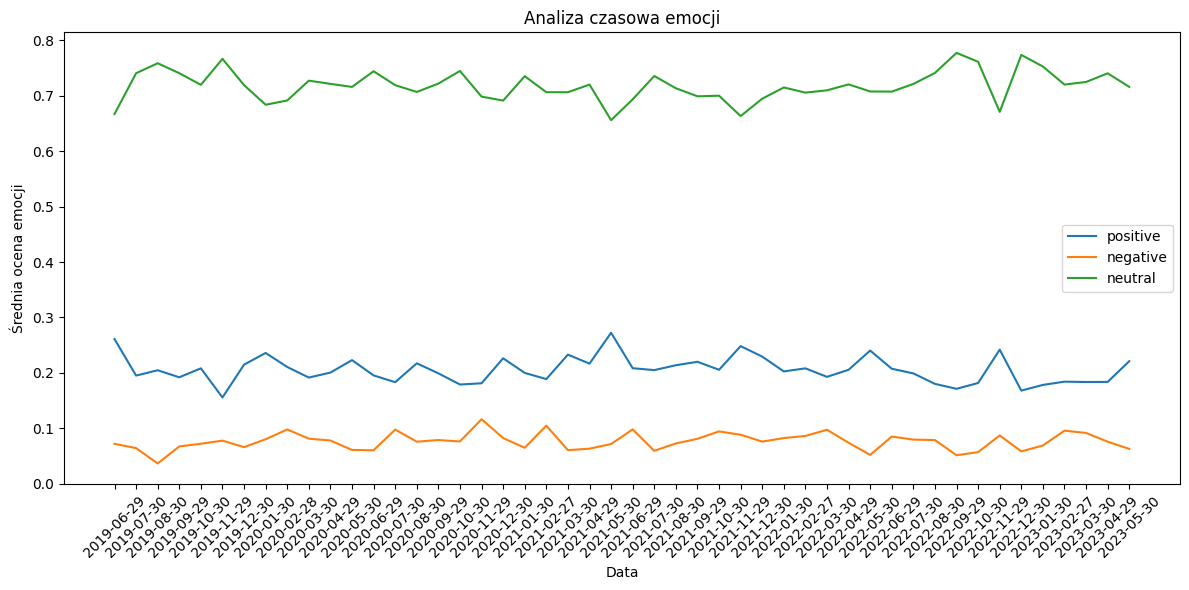

In [25]:
emotions = ['positive', 'negative', 'neutral']
progress_interval = 1000

dates_emotions = defaultdict(lambda: defaultdict(list))
progress_counter = 0

sia = SentimentIntensityAnalyzer()

for index, row in df.iterrows():
    tweet = row['Content']
    date = row['Date']

    sentiment_scores = sia.polarity_scores(tweet)

    dates_emotions[date]['positive'].append(sentiment_scores['pos'])
    dates_emotions[date]['negative'].append(sentiment_scores['neg'])
    dates_emotions[date]['neutral'].append(sentiment_scores['neu'])

    progress_counter += 1
    if progress_counter % progress_interval == 0:
        print(f'Przetworzono emocje dla {progress_counter} tweetów')

dates = list(dates_emotions.keys())
    
plt.figure(figsize=(12, 6))

for emotion in emotions:
    average_emotions = []
    for date in dates:
        scores = dates_emotions[date][emotion]
        if scores:
            average_emotions.append(sum(scores) / len(scores))
        else:
            average_emotions.append(0)
    plt.plot(dates, average_emotions, label=emotion)

plt.xlabel('Data')
plt.ylabel('Średnia ocena emocji')
plt.title('Analiza czasowa emocji')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

Na tym wykresie ciężko zauważyć jakąś analogię i związek z prawdziwymi wydarzeniami. Można o nim powiedzieć tyle, że zawsze najwięcej jest tweetów o charakterze neutralnym, oraz zawsze tweetów o wydźwięku pozytywnym jest więcej niż tych negatywnych.

## Analiza tematyki opinii

Do analizy tematyki używam **Latent Dirichlet Allocation (LDA)**. LDA próbuje znaleźć ukryte tematy poprzez analizę współwystępowania słów w dokumentach. Kod poniżej tworzy chmury oraz wykresy słupkowe dla najczęsciej występujących słów w każdym z tematów.

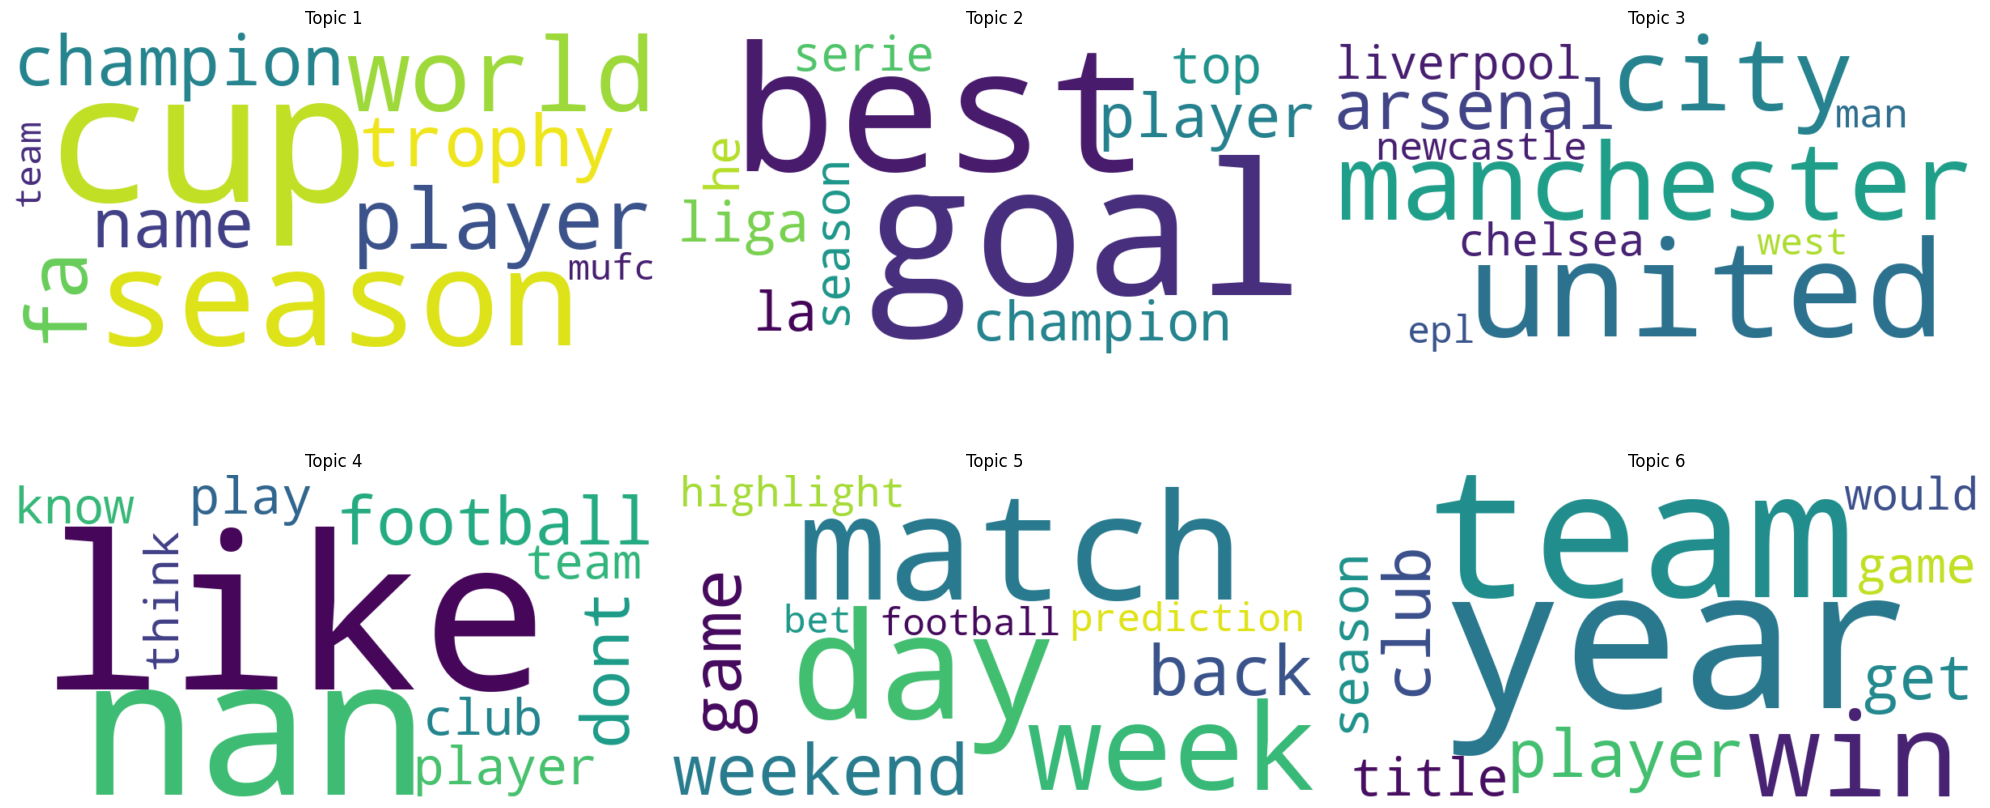

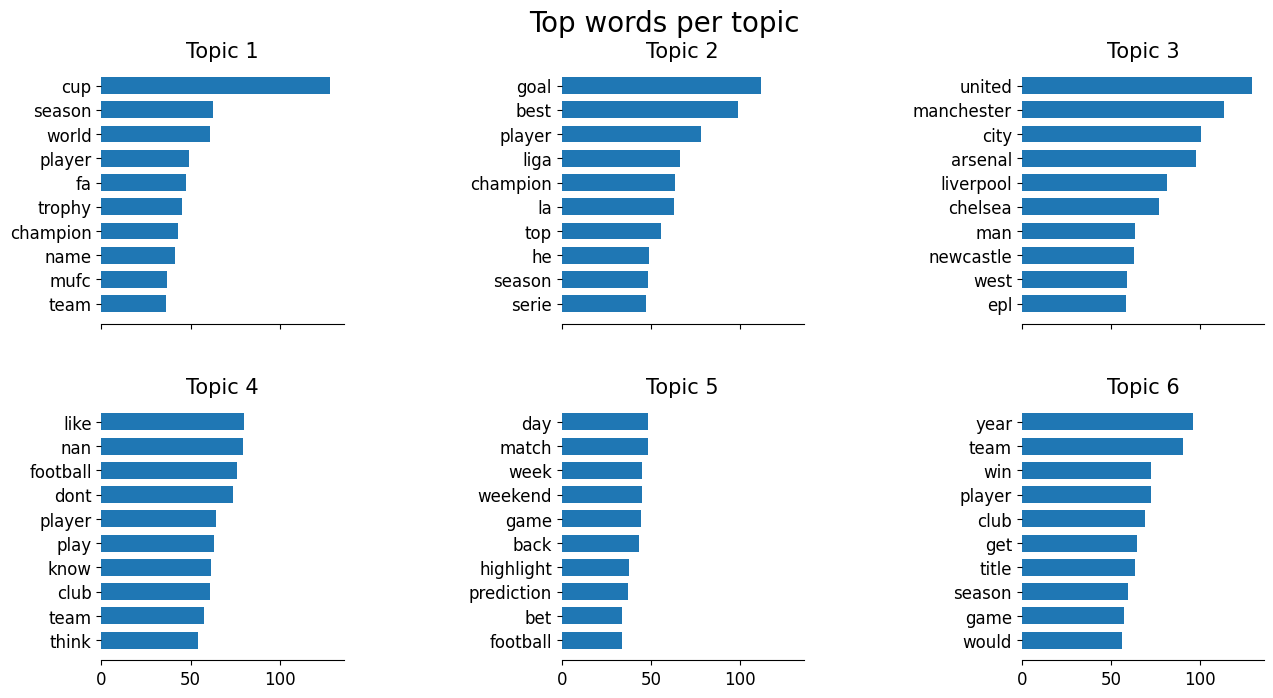

In [32]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
import seaborn as sns

vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df['Content'])

lda = LatentDirichletAllocation(n_components=6, random_state=0)
lda.fit(X)

def plot_word_clouds(model, feature_names, no_top_words):
    fig, axes = plt.subplots(2, 3, figsize=(20, 10))
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        wordcloud = WordCloud(background_color='white', width=800, height=400, max_words=no_top_words
                             ).generate_from_frequencies({feature_names[i]: topic[i] for i in topic.argsort()[:-no_top_words - 1:-1]})
        ax = axes[topic_idx]
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.set_title(f'Topic {topic_idx+1}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()
plot_word_clouds(lda, vectorizer.get_feature_names_out(), 10)

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 3, figsize=(15, 7), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        
        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx+1}', fontdict={'fontsize': 15})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=12)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=20)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

plot_top_words(lda, vectorizer.get_feature_names_out(), 10, 'Top words per topic')

## Klasteryzacja

Jest to proces grupowania zbioru danych na podstawie podobieństwa ich cech. Celem jest znalezienie naturalnych podgrup w danych, gdzie obiekty w tych samych grupach są bardziej podobne do siebie niż do obiektów w innych grupach. Kod poniżej tworzy wykres pokazujący rozkład nazwanych tematów w klastrach.

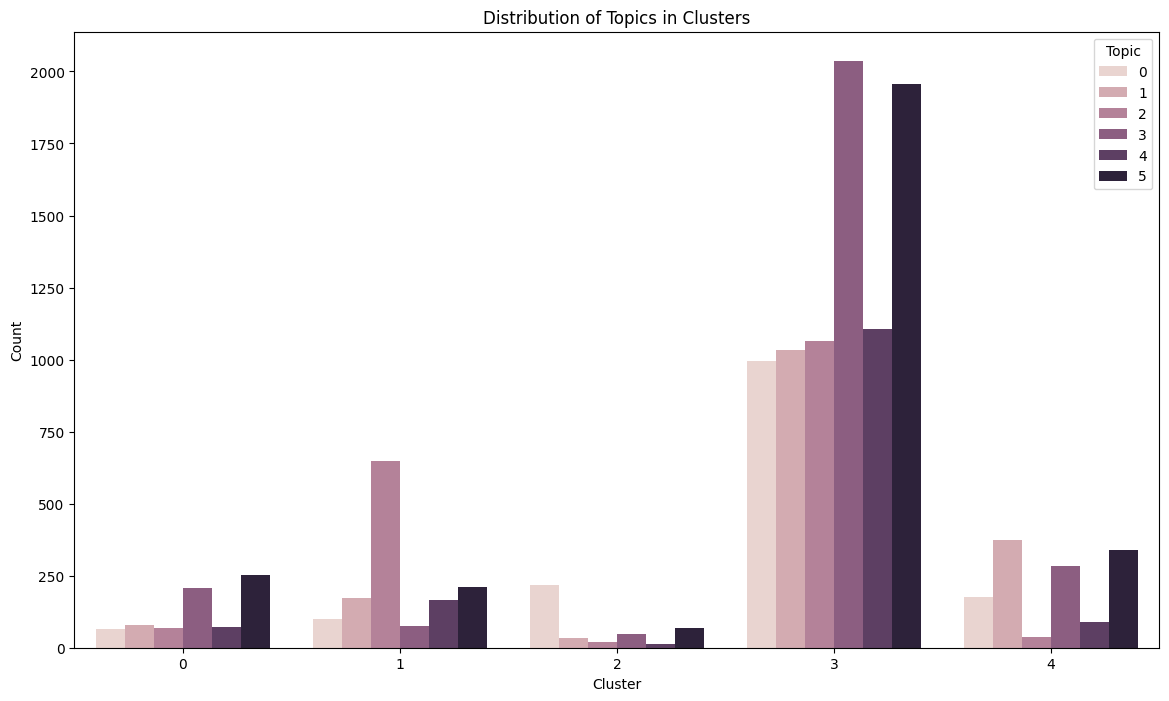

In [39]:
kmeans = KMeans(n_clusters=5, random_state=0)
clusters = kmeans.fit_predict(X)

df['Cluster'] = clusters

df['Topic'] = lda.transform(X).argmax(axis=1)
plt.figure(figsize=(14, 8))
sns.countplot(x='Cluster', hue='Topic', data=df)
plt.title('Distribution of Topics in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.legend(title='Topic', loc='upper right')
plt.show()